# Data Processing Pipeline
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from importlib import reload
# import utility functions
import utils as utils

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')
# setup OS agnostic pathnames
ROOT_DIR = Path('../..')

import DataLoader as DataLoader
reload(DataLoader)
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

dataLoader = DataLoader.DataLoader(ROOT_DIR)

# 1.Dataset Processing

Load the dataset. The following tables are loaded for this project:
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [2]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

- The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

- We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [3]:
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)

The Demographic dataframe is a combination of the patient and admission datasets. Adding some columns:
- AGE: the age of the patient at the admitted year
- IS_SEPSIS: indicating whether this is a sepsis case or not


The labevents dataframe is loaded. Admissions under 18 years old are removed

In [4]:
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)

Removed 8210 admissions with AGE < 18


We replace those with aged > 100 by the median age of patients

In [5]:
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)

The labevents dataframe is loaded. The records of admissions under 18 years old are removed.
- The empty HADM_ID is this are cleaned

In [6]:
df_labevents = dataLoader.load_labevents(df_demographic)

MemoryError: Unable to allocate 512. KiB for an array with shape (65536,) and data type int64

Calculate the TIME from for labevents from ADMITTIME to CHARTTIME
- A column NEW_ADMITTIME is added: if CHARTTIME < ADMITTIME, the NEW_ADMITTIME is the CHARTTIME, otherwise, use the ADMITTIME

In [8]:
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)
# utils.save_csv(df_labevents, ROOT_DIR / 'data/labevents_cleaned.csv')

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\Kha Huynh\Data cleansing\DataLoader.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_admittime['NEW_ADMITTIME'] = np.where(new_admittime.CHARTTIME < new_admittime.ADMITTIME, new_admittime.CHARTTIME, new_admittime.ADMITTIME)


# 2. Create train data

In [56]:
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=20)

In [ ]:
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=20)

In [74]:
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=4, feature_no=20)

In [70]:
df_final = dataLoader.create_train_data_sequence(df_labevents, df_demographic, df_desc_labitems, 4)

In [7]:
df_final = dataLoader.create_train_data_sequence(df_labevents, df_demographic, df_desc_labitems, 8, output_filename = ROOT_DIR / 'data/Model input data/t8_sequence.csv')

In [44]:
df_final = dataLoader.create_train_data_sequence_padded(df_labevents, df_demographic, df_desc_labitems, hours=4, feature_no=30, output_filename = ROOT_DIR / 'data/Model input data/t4_padded.csv')

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\Kha Huynh\Data cleansing\DataLoader.py:546: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  row_less_df = pd.concat([row_less_df, replicate_first_row], ignore_index=True)


In [115]:
df_final = dataLoader.create_train_data_sequence_new(df_labevents, df_demographic, df_desc_labitems, hours=4, feature_no=20, output_filename = ROOT_DIR / 'data/Model input data/t4_nan.csv')

In [122]:
df_final = dataLoader.create_train_data_sequence_new(df_labevents, df_demographic, df_desc_labitems, hours=3, feature_no=20, output_filename = ROOT_DIR / 'data/Model input data/t3_nan.csv')

# Create Sequential data

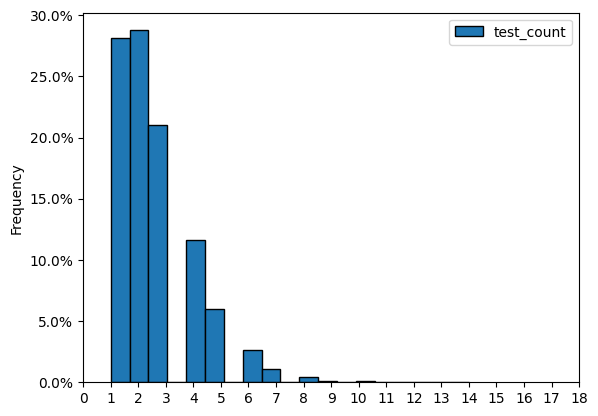

In [115]:
temp = df_labevents.drop_duplicates(['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'])

test_count_within4h = temp[temp.TIME<=4].groupby(['SUBJECT_ID', 'HADM_ID']).apply(lambda x: len(x)).reset_index(name='test_count')
test_count_within4h.test_count = test_count_within4h.test_count.astype(int)
test_count_within4h.plot(kind='hist', y='test_count', weights=np.ones(len(test_count_within4h)) / len(test_count_within4h),\
                         xticks=list(range(0, 19)), \
       edgecolor='black', bins=19)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [ ]:
temp = df_labevents.drop_duplicates(['SUBJECT_ID', 'HADM_ID', 'TIME', 'CHARTTIME'])
temp = temp.merge(df_demographic[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']])
tests_count = temp.groupby(['SUBJECT_ID', 'HADM_ID', 'TIME', 'IS_SEPSIS']).size().reset_index(name='row_count')

count_8h = tests_count[(tests_count.TIME <= 8) & (tests_count.IS_SEPSIS==1)]

for t in range(0, 9):
  count_8h[count_8h.TIME == t].plot(kind='hist', y='row_count', weights=np.ones(len(count_8h[count_8h.TIME == t])) / len(count_8h[count_8h.TIME == t]), \
                                  xticks=list(range(0, 10)), bins=11, layout=(1,2), title=f"t{t}")
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [ ]:
import sweetviz as sv
import numpy as np, warnings
np.warnings = warnings

df_final = df_final.reindex(columns=df_final.columns)

df_final.iteritems = df_final.items

analysis = sv.analyze(df_final)
analysis.show_notebook()

# Check Microbiology

In [ ]:
df_microbio = dataLoader.load_microbiologyevents()

In [479]:
# blood_cure = df_microbio[(df_microbio['SPEC_TYPE_DESC'].str.contains('blood', case=False, na=False)) & (~df_microbio.AB_ITEMID.isna())]
blood_cure = df_microbio[(~df_microbio.AB_ITEMID.isna())]

In [480]:
blood_cure.sort_values(['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'], inplace=True)

C:\Users\vicky\AppData\Local\Temp\ipykernel_8804\2248027169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blood_cure.sort_values(['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'], inplace=True)


In [481]:
blood_cure.drop_duplicates(['SUBJECT_ID', 'HADM_ID'], inplace=True)

C:\Users\vicky\AppData\Local\Temp\ipykernel_8804\373756499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blood_cure.drop_duplicates(['SUBJECT_ID', 'HADM_ID'], inplace=True)


In [482]:
df_merged = df_demographic.merge((df_labevents.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])[['SUBJECT_ID', 'HADM_ID', 'NEW_ADMITTIME']]), on=['SUBJECT_ID', 'HADM_ID'], how='left')

In [483]:
df_merged = df_merged.merge(blood_cure[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME']], on=['SUBJECT_ID', 'HADM_ID'], how='left')

In [484]:
df_merged['AB_TIME'] = np.ceil((df_merged.CHARTTIME - df_merged.NEW_ADMITTIME).dt.total_seconds() / 3600)

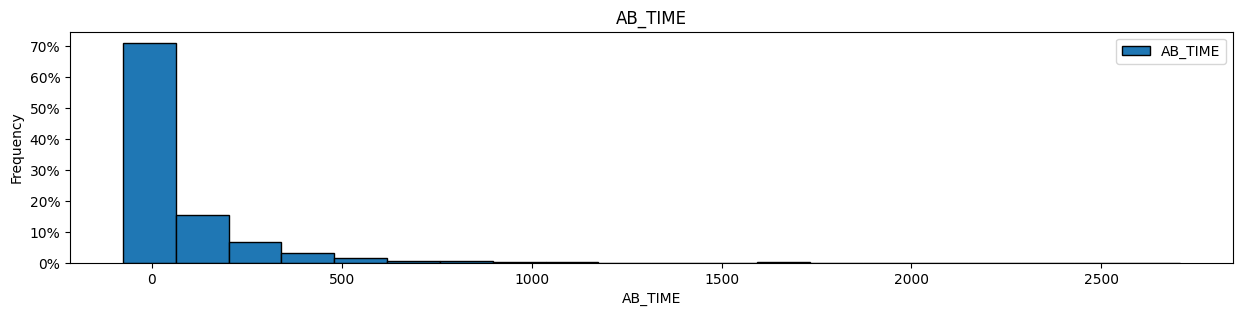

In [485]:
a = df_merged[(df_merged.IS_SEPSIS==1) & (~df_merged.AB_TIME.isna())]
a.\
  plot(kind='hist', y='AB_TIME', bins=20, \
       weights=np.ones(len(a)) / len(a),\
      #  xticks=list(range(-10, 10)), \
       edgecolor='black', title='AB_TIME', xlabel='AB_TIME', figsize=(15, 3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

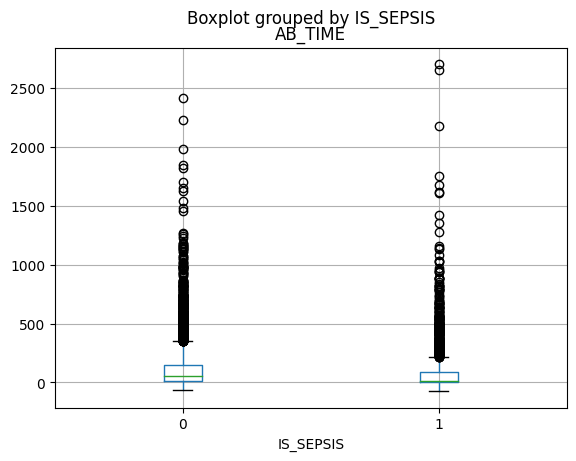

In [486]:
df_merged.boxplot('AB_TIME', by='IS_SEPSIS')
plt.show()

In [487]:
df_merged[df_merged.IS_SEPSIS == 1]['AB_TIME'].median()

10.0

In [509]:
df_merged[(df_merged.IS_SEPSIS == 1)].describe()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,EDREGTIME,EDOUTTIME,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_NUM,NEW_ADMITTIME,CHARTTIME,AB_TIME,STARTDATE,CURE_TIME
count,5176.000000,5176.000000,5176.000000,5176,5176,3827,3827,5176.000000,5176.000000,5176,5176.000000,5176.000000,5176.0,5176.00000,5173,2994,2993.000000,5172,5169.000000
mean,33209.367465,40124.125386,149325.265649,2151-09-17 12:26:15.892581376,2151-10-02 13:20:15.336166400,2151-10-31 04:16:44.196499456,2151-10-31 10:24:17.136138240,0.308153,0.997488,2068-12-07 08:39:08.068005888,0.633308,64.632921,1.0,2.15881,2151-09-19 02:01:04.836652032,2151-04-08 18:32:26.933867520,84.232543,2151-09-09 20:57:21.299304448,-18.402012
min,20.000000,21.000000,100028.000000,2100-07-02 19:28:00,2100-07-07 18:05:00,2100-07-02 14:07:00,2100-07-03 00:18:00,0.000000,0.000000,1800-07-02 00:00:00,0.000000,18.000000,1.0,0.00000,2100-07-02 14:45:00,2100-07-02 15:45:00,-76.000000,2100-07-03 00:00:00,-17435.000000
25%,18225.000000,14895.250000,124879.500000,2126-08-04 09:41:15.000000512,2126-08-15 21:06:15.000000512,2126-11-20 01:09:30,2126-11-20 09:34:00,0.000000,1.000000,2054-08-14 12:00:00,0.000000,56.000000,1.0,2.00000,2126-08-05 21:25:00,2126-02-14 08:08:15.000000512,2.000000,2126-07-30 00:00:00,-14.000000
50%,35945.500000,29477.500000,149193.500000,2151-07-24 19:08:30,2151-08-06 04:31:00,2151-08-05 18:16:00,2151-08-06 01:11:00,0.000000,1.000000,2083-03-24 00:00:00,1.000000,65.000000,1.0,2.00000,2151-07-24 23:15:00,2151-03-27 04:05:30,10.000000,2151-07-14 12:00:00,-9.000000
75%,48015.250000,65582.000000,174347.250000,2177-02-19 18:57:00,2177-03-11 15:45:15.000000512,2177-02-23 07:30:00,2177-02-23 10:30:30,1.000000,1.000000,2109-07-05 12:00:00,1.000000,76.000000,1.0,3.00000,2177-02-19 18:15:00,2176-07-15 01:58:44.999999488,88.000000,2177-02-05 12:00:00,0.000000
max,58973.000000,99991.000000,199943.000000,2209-07-31 13:51:00,2209-08-20 19:15:00,2209-07-31 09:43:00,2209-07-31 15:16:00,1.000000,1.000000,2179-12-14 00:00:00,1.000000,89.000000,1.0,3.00000,2209-07-31 09:45:00,2209-08-17 19:34:00,2706.000000,2209-07-31 00:00:00,420.000000
std,17254.018146,29666.981226,28725.062639,NaN,NaN,NaN,NaN,0.461775,0.050058,NaN,0.481948,14.678260,0.0,0.79800,NaN,NaN,182.955042,NaN,358.170010


In [489]:
df_merged[(df_merged.IS_SEPSIS == 1) & (df_merged.AB_TIME.isna())]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_cat,AGE_NUM,NEW_ADMITTIME,CHARTTIME,AB_TIME
22,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,M,2135-03-22,1,63,1,51-70,2,2198-11-01 17:20:00,NaT,NaN
33,471,366,134462,2164-11-18 20:27:00,2164-11-22 15:18:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,M,2112-05-22,0,52,1,51-70,2,2164-11-18 13:00:00,NaT,NaN
53,61,61,189535,2119-01-04 18:12:00,2119-02-03 01:35:00,2119-02-03 01:35:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,...,M,2063-10-21,1,55,1,51-70,2,2119-01-04 13:00:00,NaT,NaN
54,62,62,116009,2113-02-15 00:19:00,2113-02-19 15:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,...,M,2044-05-08,0,68,1,51-70,2,2113-02-14 20:20:00,NaT,NaN
56,64,64,172056,2143-03-03 09:25:00,2143-03-18 13:01:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicaid,...,F,2116-06-27,0,26,1,18-35,0,2143-03-03 04:33:00,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50714,58545,98656,138450,2160-07-26 18:04:00,2160-07-30 13:15:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,LONG TERM CARE HOSPITAL,Medicare,...,F,2092-07-19,0,68,1,51-70,2,2160-07-26 13:38:00,NaT,NaN
50726,58557,98698,134977,2188-10-18 02:00:00,2188-10-22 15:53:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Government,...,M,2142-12-11,0,45,1,36-50,1,2188-10-17 21:20:00,NaT,NaN
50743,58574,98744,153703,2127-10-21 12:43:00,2127-10-31 12:35:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,M,2058-01-11,0,69,1,51-70,2,2127-10-21 12:43:00,NaT,NaN
50759,58590,98769,141860,2125-02-22 22:18:00,2125-03-05 17:22:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,...,F,2044-10-22,1,80,1,71+,3,2125-02-22 21:25:00,NaT,NaN


In [491]:
df_merged[(df_merged.AB_TIME<=3) & (df_merged.IS_SEPSIS==1)].shape

(1111, 29)

In [348]:
(5176 - 3774)/5176

0.27086553323029366

In [349]:
3774 / 5176

0.7291344667697064

In [465]:
808/5176

0.1561051004636785

# PRESCRIPTIONS

In [455]:
df_prescriptions = pd.read_csv(ROOT_DIR / 'data/PRESCRIPTIONS.csv')

C:\Users\vicky\AppData\Local\Temp\ipykernel_8804\3836884500.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_prescriptions = pd.read_csv(ROOT_DIR / 'data/PRESCRIPTIONS.csv')


In [456]:
df_prescriptions

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,4.690617e+08,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,5.601728e+07,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,3.380550e+08,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0.000000e+00,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,5.482972e+07,20mg Tablet,20,mg,1,TAB,PO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4156445,3996662,98887,121032,238144.0,2144-09-06 00:00:00,2144-09-06 00:00:00,MAIN,PredniSONE,PredniSONE,PredniSONE,PRED20,006751,5.400182e+07,20 mg Tablet,40,mg,2,TAB,PO/NG
4156446,3996070,98887,121032,238144.0,2144-09-06 00:00:00,2144-09-06 00:00:00,MAIN,Ipratropium Bromide Neb,Ipratropium Bromide Neb,Ipratropium Bromide Neb,IPRA2H,021700,4.879801e+08,2.5mL Vial,1,NEB,1,VIAL,IH
4156447,3996063,98887,121032,238144.0,2144-09-06 00:00:00,2144-09-06 00:00:00,MAIN,HYDROmorphone (Dilaudid),HYDROmorphone (Dilaudid),HYDROmorphone,HYDR20/100NS,048078,6.155302e+10,20 mg / 100 mL Premix Bag,0.12,mg,0.01,BAG,IVPCA
4156448,3996062,98887,121032,238144.0,2144-09-06 00:00:00,2144-09-06 00:00:00,MAIN,Docusate Sodium,Docusate Sodium,Docusate Sodium,DOCU100,003009,9.042245e+08,100mg Capsule,100,mg,1,CAP,PO


In [386]:
df_prescriptions['STARTDATE'] = pd.to_datetime(df_prescriptions['STARTDATE'], format='%Y-%m-%d %H:%M:%S')
df_prescriptions['ENDDATE'] = pd.to_datetime(df_prescriptions['ENDDATE'], format='%Y-%m-%d %H:%M:%S')

In [420]:
df_prescriptions.sort_values(['SUBJECT_ID', 'HADM_ID', 'STARTDATE'], inplace=True)

In [421]:
first_medicated = df_prescriptions.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])

In [492]:
df_merged = df_merged.merge(first_medicated[['SUBJECT_ID', 'HADM_ID', 'STARTDATE']], on=['SUBJECT_ID', 'HADM_ID'], how='left')

In [493]:
df_merged['CURE_TIME'] = np.ceil((df_merged.STARTDATE - df_merged.NEW_ADMITTIME).dt.total_seconds() / 3600)

In [508]:
df_merged[(df_merged.IS_SEPSIS==1) & (~df_merged.CURE_TIME.isna())].describe()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,EDREGTIME,EDOUTTIME,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_NUM,NEW_ADMITTIME,CHARTTIME,AB_TIME,STARTDATE,CURE_TIME
count,5169.000000,5169.000000,5169.000000,5169,5169,3822,3822,5169.000000,5169.000000,5169,5169.000000,5169.000000,5169.0,5169.000000,5169,2992,2992.000000,5169,5169.000000
mean,33195.787580,40100.277036,149316.690849,2151-09-12 11:38:45.258269696,2151-09-27 12:45:46.767266816,2151-10-30 13:44:12.762951680,2151-10-30 19:51:52.182103040,0.307796,0.997485,2068-12-28 22:36:08.775391744,0.633004,64.626814,1.0,2.158638,2151-09-12 08:28:47.405687808,2151-04-01 03:01:50.033422336,84.233957,2151-09-11 13:37:55.333720064,-18.402012
min,20.000000,21.000000,100028.000000,2100-07-02 19:28:00,2100-07-07 18:05:00,2100-07-02 14:07:00,2100-07-03 00:18:00,0.000000,0.000000,1800-07-02 00:00:00,0.000000,18.000000,1.0,0.000000,2100-07-02 14:45:00,2100-07-02 15:45:00,-76.000000,2100-07-03 00:00:00,-17435.000000
25%,18213.000000,14887.000000,124878.000000,2126-07-30 20:30:00,2126-08-13 14:40:00,2126-11-17 08:13:44.999999488,2126-11-17 18:05:30,0.000000,1.000000,2054-08-17 00:00:00,0.000000,56.000000,1.0,2.000000,2126-07-30 17:20:00,2126-02-08 10:05:44.999999488,2.000000,2126-07-30 00:00:00,-14.000000
50%,35933.000000,29470.000000,149191.000000,2151-07-24 11:05:00,2151-08-03 14:50:00,2151-08-08 14:56:30,2151-08-08 23:23:30,0.000000,1.000000,2083-03-22 00:00:00,1.000000,65.000000,1.0,2.000000,2151-07-24 02:34:00,2151-03-21 23:36:00,10.000000,2151-07-18 00:00:00,-9.000000
75%,48015.000000,65582.000000,174346.000000,2177-02-01 05:45:00,2177-02-17 18:20:00,2177-02-14 07:45:30,2177-02-14 12:26:30,1.000000,1.000000,2109-07-01 00:00:00,1.000000,76.000000,1.0,3.000000,2177-01-31 23:30:00,2176-06-15 11:13:44.999999488,88.000000,2177-02-01 00:00:00,0.000000
max,58973.000000,99991.000000,199943.000000,2209-07-31 13:51:00,2209-08-20 19:15:00,2209-07-31 09:43:00,2209-07-31 15:16:00,1.000000,1.000000,2179-12-14 00:00:00,1.000000,89.000000,1.0,3.000000,2209-07-31 09:45:00,2209-08-17 19:34:00,2706.000000,2209-07-31 00:00:00,420.000000
std,17254.885169,29661.062543,28724.227699,NaN,NaN,NaN,NaN,0.461627,0.050091,NaN,0.482032,14.683629,0.0,0.798353,NaN,NaN,182.985608,NaN,358.170010


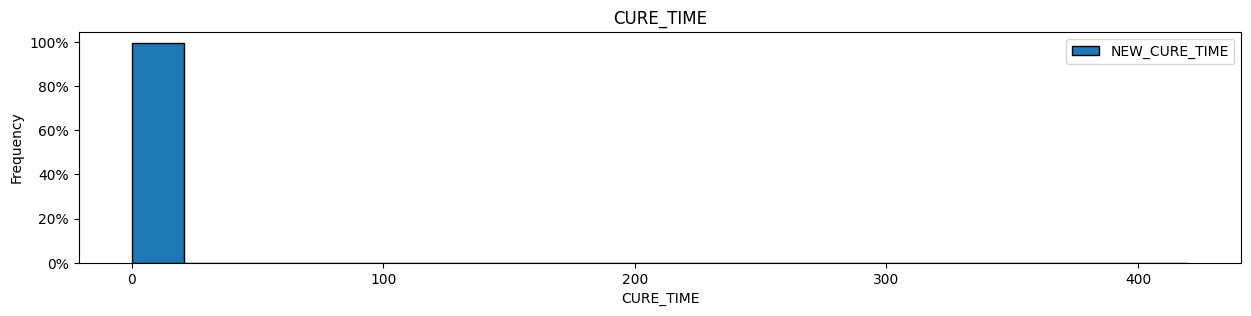

In [506]:
a = df_merged[(df_merged.IS_SEPSIS==1) & (~df_merged.AB_TIME.isna())]
a.\
  plot(kind='hist', y='NEW_CURE_TIME', bins=20, \
       weights=np.ones(len(a)) / len(a),\
      #  xticks=list(range(-10, 10)), \
       edgecolor='black', title='CURE_TIME', xlabel='CURE_TIME', figsize=(15, 3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [497]:
df_merged[(df_merged.IS_SEPSIS==1) & (df_merged.CURE_TIME<=8)]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,AGE,IS_SEPSIS,AGE_cat,AGE_NUM,NEW_ADMITTIME,CHARTTIME,AB_TIME,STARTDATE,CURE_TIME,NEW_CURE_TIME
18,40,38,185910,2166-08-10 00:28:00,2166-09-04 11:30:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,LONG TERM CARE HOSPITAL,Medicare,...,75,1,71+,3,2166-08-10 00:17:00,2166-08-11 06:30:00,31.0,2166-08-10,-0.0,-0.0
21,457,357,145674,2198-08-02 04:49:00,2198-10-26 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,63,1,51-70,2,2198-08-02 02:10:00,2198-08-04 14:17:00,61.0,2198-08-02,-2.0,0.0
22,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,63,1,51-70,2,2198-11-01 17:20:00,NaT,NaN,2198-11-01,-17.0,0.0
33,471,366,134462,2164-11-18 20:27:00,2164-11-22 15:18:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,52,1,51-70,2,2164-11-18 13:00:00,NaT,NaN,2164-11-18,-13.0,0.0
53,61,61,189535,2119-01-04 18:12:00,2119-02-03 01:35:00,2119-02-03 01:35:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,...,55,1,51-70,2,2119-01-04 13:00:00,NaT,NaN,2119-01-04,-13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50735,58566,98724,186754,2143-08-22 16:01:00,2143-09-02 17:15:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,REHAB/DISTINCT PART HOSP,Medicare,...,84,1,71+,3,2143-08-22 11:17:00,2143-08-22 12:17:00,1.0,2143-08-22,-11.0,0.0
50740,58571,98744,168288,2127-06-10 19:22:00,2127-06-18 11:51:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,69,1,51-70,2,2127-06-10 10:15:00,2127-06-10 14:00:00,4.0,2127-06-10,-10.0,0.0
50743,58574,98744,153703,2127-10-21 12:43:00,2127-10-31 12:35:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,69,1,51-70,2,2127-10-21 12:43:00,NaT,NaN,2127-10-21,-12.0,0.0
50759,58590,98769,141860,2125-02-22 22:18:00,2125-03-05 17:22:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,...,80,1,71+,3,2125-02-22 21:25:00,NaT,NaN,2125-02-23,3.0,3.0


In [498]:
df_merged[(df_merged.IS_SEPSIS==1) & (df_merged.NEW_ADMITTIME.dt.date==df_merged.STARTDATE) & (~df_merged.CHARTTIME.isna())]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,AGE,IS_SEPSIS,AGE_cat,AGE_NUM,NEW_ADMITTIME,CHARTTIME,AB_TIME,STARTDATE,CURE_TIME,NEW_CURE_TIME
18,40,38,185910,2166-08-10 00:28:00,2166-09-04 11:30:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,LONG TERM CARE HOSPITAL,Medicare,...,75,1,71+,3,2166-08-10 00:17:00,2166-08-11 06:30:00,31.0,2166-08-10,-0.0,-0.0
21,457,357,145674,2198-08-02 04:49:00,2198-10-26 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,63,1,51-70,2,2198-08-02 02:10:00,2198-08-04 14:17:00,61.0,2198-08-02,-2.0,0.0
132,169,124,138376,2165-12-31 18:55:00,2166-02-01 06:55:00,2166-02-01 06:55:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,75,1,71+,3,2165-12-31 18:55:00,2166-01-13 11:51:00,305.0,2165-12-31,-18.0,0.0
155,195,145,138459,2145-02-15 17:19:00,2145-02-22 13:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,...,55,1,51-70,2,2145-02-15 00:49:00,2145-02-15 22:15:00,22.0,2145-02-15,-0.0,-0.0
170,152,111,155897,2144-07-01 04:12:00,2144-07-01 14:55:00,2144-07-01 14:55:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,69,1,51-70,2,2144-07-01 01:50:00,2144-07-01 07:42:00,6.0,2144-07-01,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50624,57759,96232,153969,2162-03-17 08:00:00,2162-04-29 13:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,REHAB/DISTINCT PART HOSP,Private,...,63,1,51-70,2,2162-03-17 08:00:00,2162-04-14 04:49:00,669.0,2162-03-17,-8.0,0.0
50637,57772,96259,113651,2189-09-14 18:14:00,2189-10-03 14:35:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,LONG TERM CARE HOSPITAL,Medicare,...,56,1,51-70,2,2189-09-14 14:40:00,2189-09-24 18:46:00,245.0,2189-09-14,-14.0,0.0
50716,58547,98665,145585,2159-05-24 16:43:00,2159-06-02 15:21:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,62,1,51-70,2,2159-05-24 12:00:00,2159-05-24 13:00:00,1.0,2159-05-24,-12.0,0.0
50735,58566,98724,186754,2143-08-22 16:01:00,2143-09-02 17:15:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,REHAB/DISTINCT PART HOSP,Medicare,...,84,1,71+,3,2143-08-22 11:17:00,2143-08-22 12:17:00,1.0,2143-08-22,-11.0,0.0


In [472]:
4983 / 5176

0.9627125193199382